In [23]:
import os
import gc
import json
import psutil
import numpy as np
import pandas as pd
import torch
import librosa
import soundfile as sf
from pathlib import Path
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2Processor
from datasets import Dataset
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')


In [24]:
import torch
import torchaudio
print(torch.__version__)
print(torchaudio.__version__)


2.7.0+cu126
2.7.0+cu126


In [25]:

# Configure torchaudio backend
try:
    import torchaudio
    # Try to set the backend
    try:
        torchaudio.set_audio_backend("sox_io")
        print(" torchaudio backend set to sox_io")
    except:
        try:
            torchaudio.set_audio_backend("soundfile")
            print(" torchaudio backend set to soundfile")
        except:
            print(" torchaudio backend configuration failed, will use librosa/soundfile")
            torchaudio = None
except ImportError:
    print(" torchaudio not available, will use librosa/soundfile")
    torchaudio = None

 torchaudio backend set to sox_io


In [26]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

# Memory optimization settings
RECOMMENDED_BATCH_SIZE = 16 if device.type == 'cuda' else 8

# OPTIMIZED SETTINGS
BATCH_SIZE = min(RECOMMENDED_BATCH_SIZE, 8)  # Conservative for stability
MAX_AUDIO_LENGTH = 16000 * 4  # Reduced to 4 seconds (was 5)
TARGET_SAMPLING_RATE = 16000
SAVE_EVERY_N_BATCHES = 10  # Save progress more frequently

# Output directory
OUTPUT_DIR = Path("/teamspace/studios/this_studio/speechSentimentAnalysis/processed_data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f" Optimized settings:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max audio length: {MAX_AUDIO_LENGTH/16000:.1f} seconds")
print(f"  Save frequency: Every {SAVE_EVERY_N_BATCHES} batches")

def load_audio_memory_efficient(file_path, target_sr=TARGET_SAMPLING_RATE, max_length=MAX_AUDIO_LENGTH):
    """
    Memory-efficient audio loading with multiple backend fallbacks
    """
    try:
        # Method 1: Try librosa first (most reliable)
        try:
            speech_array, sampling_rate = librosa.load(file_path, sr=None)
            speech_array = torch.tensor(speech_array)
            if speech_array.dim() == 1:
                speech_array = speech_array.unsqueeze(0)
            backend_used = "librosa"
        except Exception as e:
            print(f" librosa failed for {file_path}: {e}")
            
            # Method 2: Try soundfile as fallback
            try:
                speech_array, sampling_rate = sf.read(file_path)
                speech_array = torch.tensor(speech_array)
                if speech_array.dim() == 1:
                    speech_array = speech_array.unsqueeze(0)
                elif speech_array.dim() == 2:
                    speech_array = speech_array.T  # soundfile returns (samples, channels)
                backend_used = "soundfile"
            except Exception as e2:
                print(f" soundfile failed for {file_path}: {e2}")
                
                # Method 3: Try torchaudio as final fallback (if available)
                if torchaudio is not None:
                    try:
                        speech_array, sampling_rate = torchaudio.load(file_path)
                        backend_used = "torchaudio"
                    except Exception as e3:
                        print(f" All backends failed for {file_path}: {e3}")
                        return None, None
                else:
                    print(f" All available backends failed for {file_path}")
                    return None, None
        
        # Convert to mono immediately to save memory
        if speech_array.shape[0] > 1:
            speech_array = speech_array.mean(dim=0, keepdim=True)
        
        # Resample if needed
        if sampling_rate != target_sr:
            # Use librosa for resampling (most reliable)
            speech_array = speech_array.squeeze().numpy()
            speech_array = librosa.resample(speech_array, orig_sr=sampling_rate, target_sr=target_sr)
            speech_array = torch.tensor(speech_array)
        
        # Squeeze and truncate/pad
        if speech_array.dim() > 1:
            speech_array = speech_array.squeeze()
        
        if len(speech_array) > max_length:
            speech_array = speech_array[:max_length]
        elif len(speech_array) < max_length:
            # Pad with zeros
            padding = max_length - len(speech_array)
            speech_array = torch.nn.functional.pad(speech_array, (0, padding))
        
        # Convert to numpy immediately and cleanup tensor
        result = speech_array.numpy().astype(np.float32)
        del speech_array
        
        return result, target_sr
        
    except Exception as e:
        print(f" Critical error loading {file_path}: {e}")
        # Return silence as fallback
        return np.zeros(max_length, dtype=np.float32), target_sr

 Using device: cpu
 Optimized settings:
  Batch size: 8
  Max audio length: 4.0 seconds
  Save frequency: Every 10 batches


In [27]:

class StreamingAudioProcessor:
    """
    Memory-efficient streaming processor that saves intermediate results
    """
    def __init__(self, output_dir, batch_size=BATCH_SIZE):
        self.output_dir = Path(output_dir)
        self.batch_size = batch_size
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")
        self.processed_samples = []
        self.batch_count = 0
        self.failed_files = []
        
    def process_single_file(self, file_path, label_id, label, dataset):
        """Process a single audio file with improved error handling"""
        try:
            # Load audio with fallback methods
            speech_array, sr = load_audio_memory_efficient(file_path)
            
            if speech_array is None:
                self.failed_files.append(file_path)
                return None
            
            # Check for valid audio data
            if np.all(speech_array == 0) or np.isnan(speech_array).any():
                print(f" Invalid audio data in {file_path}")
                self.failed_files.append(file_path)
                return None
            
            # Process with Wav2Vec2 - WITHOUT truncation parameters
            inputs = self.processor(
                speech_array, 
                sampling_rate=sr, 
                return_tensors="pt",
                padding=True
            )
            
            # Extract and convert to list (save memory)
            input_values = inputs['input_values'].squeeze().tolist()
            
            # Clean up tensors immediately
            del inputs
            del speech_array
            
            return {
                'input_values': input_values,
                'labels': int(label_id),
                'label': label,
                'dataset': dataset,
                'path': str(file_path)
            }
            
        except Exception as e:
            print(f" Error processing {file_path}: {e}")
            self.failed_files.append(file_path)
            return None
    
    def save_batch(self, batch_samples, batch_idx):
        """Save a batch of processed samples"""
        if not batch_samples:
            return None
        
        batch_df = pd.DataFrame(batch_samples)
        batch_file = self.output_dir / f"batch_{batch_idx:04d}.parquet"
        batch_df.to_parquet(batch_file)
        
        # Clear the batch from memory
        del batch_df
        del batch_samples
        gc.collect()
        
        return batch_file
    
    def combine_batches(self, batch_files, output_name):
        """Combine batch files into final dataset"""
        if not batch_files:
            return None
            
        print(f" Combining {len(batch_files)} batch files...")
        
        # Read all batch files
        all_batches = []
        for batch_file in batch_files:
            if batch_file and batch_file.exists():
                batch_df = pd.read_parquet(batch_file)
                all_batches.append(batch_df)
        
        if not all_batches:
            print(" No valid batch files to combine")
            return None
        
        # Combine all batches
        combined_df = pd.concat(all_batches, ignore_index=True)
        
        # Save combined dataset
        output_file = self.output_dir / f"{output_name}.parquet"
        combined_df.to_parquet(output_file)
        
        # Clean up batch files
        for batch_file in batch_files:
            if batch_file and batch_file.exists():
                batch_file.unlink()
        
        # Clean up memory
        del all_batches
        del combined_df
        gc.collect()
        
        return output_file
    
    def process_dataset_streaming(self, dataset_df, dataset_name):
        """Process dataset in streaming fashion"""
        print(f"\n Processing {dataset_name} in streaming mode...")
        
        total_samples = len(dataset_df)
        processed_count = 0
        batch_files = []
        current_batch = []
        
        for idx, row in dataset_df.iterrows():
            # Process single file
            sample = self.process_single_file(
                row['path'], 
                row['label_id'], 
                row['label'], 
                row['dataset']
            )
            
            if sample:
                current_batch.append(sample)
                processed_count += 1
            
            # Save batch when full or at end
            if len(current_batch) >= self.batch_size or idx == total_samples - 1:
                if current_batch:
                    batch_file = self.save_batch(current_batch, self.batch_count)
                    if batch_file:
                        batch_files.append(batch_file)
                    current_batch = []
                    self.batch_count += 1
                    
                    # Progress update
                    progress = (processed_count / total_samples) * 100
                    print(f"  Processed {processed_count}/{total_samples} ({progress:.1f}%)")
                    
                    # Aggressive memory cleanup
                    if self.batch_count % SAVE_EVERY_N_BATCHES == 0:
                        gc.collect()
                        if device.type == 'cuda':
                            torch.cuda.empty_cache()
                        get_memory_usage()
        
        # Report failed files
        if self.failed_files:
            failed_count = len(self.failed_files)
            print(f" {failed_count} files failed to process")
            
            # Save failed files list
            failed_file = self.output_dir / f"failed_files_{dataset_name}.txt"
            with open(failed_file, 'w') as f:
                for failed in self.failed_files:
                    f.write(f"{failed}\n")
            
            self.failed_files = []  # Reset for next dataset
        
        print(f" {dataset_name}: {processed_count} samples processed in {len(batch_files)} batches")
        return batch_files, processed_count

In [28]:

def validate_audio_file(file_path):
    """Validate that an audio file exists and is readable"""
    if not os.path.exists(file_path):
        return False
    
    try:
        # Quick validation - just check if file can be opened
        with open(file_path, 'rb') as f:
            header = f.read(12)
            # Check for common audio file headers
            if header.startswith(b'RIFF') or header.startswith(b'ID3') or header.startswith(b'\xff\xfb'):
                return True
        return False
    except:
        return False

def load_datasets():
    """Load all datasets with improved file validation"""
    BASE_DIR = "/teamspace/studios/this_studio/speechSentimentAnalysis/data/input"
    all_entries = []
    
    print(f" Loading datasets from: {BASE_DIR}")
    
    # RAVDESS
    ravdess_path = os.path.join(BASE_DIR, "Ravdess/audio_speech_actors_01-24")
    if os.path.exists(ravdess_path):
        print("Loading RAVDESS...")
        for actor in os.listdir(ravdess_path):
            actor_path = os.path.join(ravdess_path, actor)
            if os.path.isdir(actor_path):
                for file in os.listdir(actor_path):
                    if file.endswith(".wav"):
                        file_path = os.path.join(actor_path, file)
                        if validate_audio_file(file_path):
                            parts = file.split('.')[0].split('-')
                            if len(parts) >= 3:
                                emotion_id = int(parts[2])
                                label_map = {
                                    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
                                    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
                                }
                                label = label_map.get(emotion_id, 'unknown')
                                all_entries.append({
                                    "path": file_path,
                                    "label": label,
                                    "dataset": "ravdess"
                                })
    
    # CREMA-D
    crema_path = os.path.join(BASE_DIR, "Crema")
    if os.path.exists(crema_path):
        print("Loading CREMA-D...")
        for file in os.listdir(crema_path):
            if file.endswith(".wav"):
                file_path = os.path.join(crema_path, file)
                if validate_audio_file(file_path):
                    parts = file.split('_')
                    if len(parts) >= 3:
                        emotion_code = parts[2]
                        label_map = {
                            'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust',
                            'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'
                        }
                        label = label_map.get(emotion_code, 'unknown')
                        all_entries.append({
                            "path": file_path,
                            "label": label,
                            "dataset": "crema"
                        })
    
    # TESS
    tess_path = os.path.join(BASE_DIR, "Tess")
    if os.path.exists(tess_path):
        print("Loading TESS...")
        for speaker_dir in os.listdir(tess_path):
            speaker_path = os.path.join(tess_path, speaker_dir)
            if os.path.isdir(speaker_path):
                for file in os.listdir(speaker_path):
                    if file.endswith(".wav"):
                        file_path = os.path.join(speaker_path, file)
                        if validate_audio_file(file_path):
                            parts = file.split('.')[0].split('_')
                            if len(parts) >= 3:
                                emotion_code = parts[2]
                                label = 'surprise' if emotion_code == 'ps' else emotion_code.lower()
                                all_entries.append({
                                    "path": file_path,
                                    "label": label,
                                    "dataset": "tess"
                                })
    
    # SAVEE
    savee_path = os.path.join(BASE_DIR, "Savee")
    if os.path.exists(savee_path):
        print("Loading SAVEE...")
        for file in os.listdir(savee_path):
            if file.endswith(".wav"):
                file_path = os.path.join(savee_path, file)
                if validate_audio_file(file_path):
                    parts = file.split('_')
                    if len(parts) >= 2:
                        emo = parts[1]
                        code = emo[:2] if emo.startswith('sa') else emo[0]
                        label_map = {
                            'a': 'angry', 'd': 'disgust', 'f': 'fear', 'h': 'happy',
                            'n': 'neutral', 'sa': 'sad', 'su': 'surprise'
                        }
                        label = label_map.get(code, 'unknown')
                        all_entries.append({
                            "path": file_path,
                            "label": label,
                            "dataset": "savee"
                        })
    
    # Create DataFrame and clean
    df = pd.DataFrame(all_entries)
    df = df[df["label"] != "unknown"]
    
    # Create label mappings
    label_list = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(label_list)}
    id2label = {idx: label for label, idx in label2id.items()}
    
    df["label_id"] = df["label"].map(label2id)
    
    print(f" Loaded {len(df)} total samples")
    print(f" Labels: {label_list}")
    print(f" Dataset distribution:")
    print(df['dataset'].value_counts())
    
    return df, label2id, id2label

In [29]:

def main():
    print(" Starting Memory-Optimized Processing Pipeline")
    print("=" * 60)
    
    # Load datasets
    df, label2id, id2label = load_datasets()
    
    # Save metadata
    metadata_path = OUTPUT_DIR / "metadata.csv"
    df.to_csv(metadata_path, index=False)
    
    # Save label mappings
    with open(OUTPUT_DIR / "label_mappings.json", "w") as f:
        json.dump({"label2id": label2id, "id2label": id2label}, f, indent=2)
    
    # Split dataset
    print("\n Splitting dataset...")
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    print(f"  Train: {len(train_df)} samples")
    print(f"  Validation: {len(valid_df)} samples")
    print(f"  Test: {len(test_df)} samples")
    
    # Initialize processor
    processor = StreamingAudioProcessor(OUTPUT_DIR, BATCH_SIZE)
    
    # Process each split
    datasets = [
        (train_df, "train"),
        (valid_df, "valid"),
        (test_df, "test")
    ]
    
    for dataset_df, name in datasets:
        print(f"\n{'='*60}")
        print(f"Processing {name.upper()} dataset")
        print('='*60)
        
        # Process in streaming mode
        batch_files, processed_count = processor.process_dataset_streaming(dataset_df, name)
        
        # Combine batches
        if batch_files:
            final_path = processor.combine_batches(batch_files, f"{name}_processed")
            if final_path:
                print(f" {name} dataset: {processed_count} samples saved to {final_path}")
            else:
                print(f" Failed to create {name} dataset")
        
        # Reset batch counter for next dataset
        processor.batch_count = 0
    
    print(f"\n All processing complete!")
    print(f" Output directory: {OUTPUT_DIR}")
    print(f" Files created:")
    print(f"  - metadata.csv")
    print(f"  - label_mappings.json")
    print(f"  - train_processed.parquet")
    print(f"  - valid_processed.parquet")
    print(f"  - test_processed.parquet")

def load_processed_datasets():
    try:
        train_df = pd.read_parquet(OUTPUT_DIR / "train_processed.parquet")
        valid_df = pd.read_parquet(OUTPUT_DIR / "valid_processed.parquet")
        test_df = pd.read_parquet(OUTPUT_DIR / "test_processed.parquet")
        
        train_dataset = Dataset.from_pandas(train_df)
        valid_dataset = Dataset.from_pandas(valid_df)
        test_dataset = Dataset.from_pandas(test_df)
        
        print(f" Loaded processed datasets:")
        print(f"  Train: {len(train_dataset)} samples")
        print(f"  Validation: {len(valid_dataset)} samples")
        print(f"  Test: {len(test_dataset)} samples")
        
        return train_dataset, valid_dataset, test_dataset
        
    except Exception as e:
        print(f" Error loading processed datasets: {e}")
        return None, None, None

def get_memory_usage():
    """Check current memory usage"""
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    print(f" Current memory usage: {memory_mb:.1f} MB")
    return memory_mb

def install_audio_backends():
    """Install required audio processing libraries"""
    print(" Installing audio backends...")
    
    # Install core audio libraries
    os.system("pip install librosa soundfile")
    
    # Try to install torchaudio backend dependencies
    try:
        # For sox backend
        os.system("apt-get update && apt-get install -y sox libsox-dev")
        print(" sox backend installed")
    except:
        print(" sox backend installation failed")
    
    try:
        # For soundfile backend
        os.system("apt-get install -y libsndfile1")
        print(" libsndfile installed")
    except:
        print(" libsndfile installation failed")
    
    print(" Audio backends installation complete")

def check_audio_backends():
    """Check which audio backends are available"""
    print(" Checking available audio backends...")
    
    # Check librosa
    try:
        import librosa
        print(" librosa available")
    except ImportError:
        print(" librosa not available")
    
    # Check soundfile
    try:
        import soundfile as sf
        print(" soundfile available")
    except ImportError:
        print(" soundfile not available")
    
    # Check torchaudio
    if torchaudio is not None:
        try:
            # Test torchaudio with a simple tensor
            test_tensor = torch.randn(1, 1000)
            print(" torchaudio available")
        except Exception as e:
            print(f" torchaudio issues: {e}")
    else:
        print(" torchaudio not available")

if __name__ == "__main__":

    print(" Initializing audio processing environment...")
    
    check_audio_backends()
    
    try:
        import librosa
        import soundfile as sf
        print(" All required audio libraries available")
    except ImportError:
        install_audio_backends()
        import librosa
        import soundfile as sf
    
    main()
    

 Initializing audio processing environment...
 Checking available audio backends...
 librosa available
 soundfile available
 torchaudio available
 All required audio libraries available
 Starting Memory-Optimized Processing Pipeline
 Loading datasets from: /teamspace/studios/this_studio/speechSentimentAnalysis/data/input
Loading RAVDESS...
Loading CREMA-D...


Loading TESS...
Loading SAVEE...
 Loaded 12099 total samples
 Labels: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
 Dataset distribution:
dataset
crema      7441
tess       2798
ravdess    1440
savee       420
Name: count, dtype: int64

 Splitting dataset...
  Train: 9679 samples
  Validation: 1210 samples
  Test: 1210 samples

Processing TRAIN dataset

 Processing train in streaming mode...
  Processed 8/9679 (0.1%)
  Processed 16/9679 (0.2%)
  Processed 24/9679 (0.2%)
  Processed 32/9679 (0.3%)
  Processed 40/9679 (0.4%)
  Processed 48/9679 (0.5%)
  Processed 56/9679 (0.6%)
  Processed 64/9679 (0.7%)
  Processed 72/9679 (0.7%)
  Processed 80/9679 (0.8%)
 Current memory usage: 763.2 MB
  Processed 88/9679 (0.9%)
  Processed 96/9679 (1.0%)
  Processed 104/9679 (1.1%)
  Processed 112/9679 (1.2%)
  Processed 120/9679 (1.2%)
  Processed 128/9679 (1.3%)
  Processed 136/9679 (1.4%)
  Processed 144/9679 (1.5%)
  Processed 152/9679 (1.6%)
  Processed 160/9679 (1

### Fixing label issue

In [5]:
import pandas as pd
import json
from pathlib import Path
import gc
import time
import pyarrow.parquet as pq
import pyarrow as pa

def force_cleanup():
    """Aggressive memory cleanup"""
    gc.collect()
    time.sleep(0.2)

def get_chunk_size(file_size_mb, available_ram_gb):
    """Calculate safe chunk size based on available RAM"""
    # Use only 25% of available RAM for chunk processing
    safe_ram_mb = available_ram_gb * 1024 * 0.25
    
    # Estimate rows per MB (rough estimate for parquet)
    estimated_rows_per_mb = 1000  # Conservative estimate
    
    # Calculate safe chunk size
    max_chunk_mb = min(safe_ram_mb, 100)  # Cap at 100MB chunks
    chunk_rows = int(max_chunk_mb * estimated_rows_per_mb)
    
    # Ensure minimum chunk size
    chunk_rows = max(chunk_rows, 1000)
    
    print(f"  File size: {file_size_mb:.1f}MB, Available RAM: {available_ram_gb:.1f}GB")
    print(f"  Using chunk size: {chunk_rows:,} rows (~{max_chunk_mb:.1f}MB)")
    
    return chunk_rows

def scan_labels_chunked(file_path, chunk_size=10000):
    """Scan file for labels using chunked reading"""
    print(f"  Scanning labels in {file_path.name}...")
    
    try:
        # Get parquet file info
        pf = pq.ParquetFile(file_path)
        total_rows = pf.metadata.num_rows
        
        print(f"  Total rows: {total_rows:,}")
        
        all_labels = set()
        neutral_count = 0
        
        # Use pandas read_parquet with iterator approach
        current_row = 0
        
        while current_row < total_rows:
            # Calculate rows to read
            rows_to_read = min(chunk_size, total_rows - current_row)
            
            # Read chunk using pandas
            df_chunk = pd.read_parquet(file_path, columns=['label'])
            
            # If file is small enough, just process it all
            if len(df_chunk) <= chunk_size:
                # Process entire file
                if 'label' in df_chunk.columns:
                    all_labels.update(df_chunk['label'].unique())
                    neutral_count += (df_chunk['label'] == 'neutral').sum()
                
                del df_chunk
                force_cleanup()
                break
            else:
                # File is large, use chunked approach
                del df_chunk  # Release the full file
                
                # Read in smaller chunks using row groups
                for i in range(0, total_rows, chunk_size):
                    try:
                        # Use row group reading
                        df_chunk = pd.read_parquet(file_path, columns=['label'])
                        
                        # Take only the chunk we want
                        start_idx = i
                        end_idx = min(i + chunk_size, total_rows)
                        
                        if len(df_chunk) > end_idx:
                            df_chunk = df_chunk.iloc[start_idx:end_idx]
                        
                        if 'label' in df_chunk.columns:
                            all_labels.update(df_chunk['label'].unique())
                            neutral_count += (df_chunk['label'] == 'neutral').sum()
                        
                        del df_chunk
                        force_cleanup()
                        
                        if i % (chunk_size * 10) == 0:
                            print(f"    Processed {i:,}/{total_rows:,} rows...")
                        
                    except Exception as chunk_error:
                        print(f"    Error processing chunk {i}: {chunk_error}")
                        continue
                
                break
        
        print(f"  Found labels: {sorted(all_labels)}")
        print(f"  Neutral count: {neutral_count}")
        
        return all_labels, neutral_count
        
    except Exception as e:
        print(f"  Error scanning {file_path.name}: {e}")
        return set(), 0

def replace_neutral_chunked(file_path, chunk_size=10000):
    """Replace neutral labels with calm using simple approach"""
    print(f"  Replacing neutral with calm in {file_path.name}...")
    
    try:
        # For small files, just process directly
        file_size_mb = file_path.stat().st_size / 1024 / 1024
        
        if file_size_mb < 500:  # If less than 500MB, process directly
            print(f"  Processing small file directly ({file_size_mb:.1f}MB)")
            
            df = pd.read_parquet(file_path)
            
            if 'label' in df.columns:
                neutral_count = (df['label'] == 'neutral').sum()
                if neutral_count > 0:
                    df.loc[df['label'] == 'neutral', 'label'] = 'calm'
                    print(f"  Replaced {neutral_count} neutral labels")
                    
                    # Save back
                    df.to_parquet(file_path, compression='snappy')
                    print(f"  ✓ Saved {file_path.name}")
                else:
                    print(f"  No neutral labels found")
            
            del df
            force_cleanup()
            return True
            
        else:
            # For large files, use chunked approach with temporary file
            print(f"  Processing large file in chunks ({file_size_mb:.1f}MB)")
            
            # Create temporary file path
            temp_file = file_path.with_suffix('.processing.parquet')
            
            # Read original file
            df = pd.read_parquet(file_path)
            total_rows = len(df)
            
            print(f"  Total rows: {total_rows:,}")
            
            # Process in chunks
            processed_chunks = []
            
            for i in range(0, total_rows, chunk_size):
                end_idx = min(i + chunk_size, total_rows)
                
                # Get chunk
                df_chunk = df.iloc[i:end_idx].copy()
                
                # Replace neutral with calm
                if 'label' in df_chunk.columns:
                    df_chunk.loc[df_chunk['label'] == 'neutral', 'label'] = 'calm'
                
                processed_chunks.append(df_chunk)
                
                # Clean up
                del df_chunk
                force_cleanup()
                
                if i % (chunk_size * 10) == 0:
                    print(f"    Processed {i:,}/{total_rows:,} rows...")
            
            # Combine and save
            print(f"  Combining {len(processed_chunks)} chunks...")
            df_final = pd.concat(processed_chunks, ignore_index=True)
            
            # Clean up chunks
            del processed_chunks
            del df
            force_cleanup()
            
            # Save to temporary file first
            df_final.to_parquet(temp_file, compression='snappy')
            
            # Clean up final df
            del df_final
            force_cleanup()
            
            # Replace original file
            temp_file.replace(file_path)
            print(f"  ✓ Replaced {file_path.name}")
            
            return True
        
    except Exception as e:
        print(f"  ✗ Error replacing labels in {file_path.name}: {e}")
        
        # Clean up temp file if it exists
        temp_file = file_path.with_suffix('.processing.parquet')
        if temp_file.exists():
            temp_file.unlink()
        
        return False

def add_label_ids_chunked(file_path, label2id, chunk_size=10000):
    """Add label IDs using simple chunked processing"""
    print(f"  Adding label IDs to {file_path.name}...")
    
    try:
        # For small files, process directly
        file_size_mb = file_path.stat().st_size / 1024 / 1024
        
        if file_size_mb < 500:  # If less than 500MB, process directly
            print(f"  Processing small file directly ({file_size_mb:.1f}MB)")
            
            df = pd.read_parquet(file_path)
            
            if 'label' in df.columns:
                # Add label IDs
                df['labels'] = df['label'].map(label2id)
                df['labels'] = df['labels'].fillna(-1).astype(int)
                
                # Show some stats
                id_counts = df['labels'].value_counts()
                print(f"  ID distribution: {dict(list(id_counts.items())[:3])}...")
                
                # Save back
                df.to_parquet(file_path, compression='snappy')
                print(f"  ✓ Saved {file_path.name}")
            
            del df
            force_cleanup()
            return True
            
        else:
            # For large files, use chunked approach
            print(f"  Processing large file in chunks ({file_size_mb:.1f}MB)")
            
            # Create temporary file path
            temp_file = file_path.with_suffix('.processing.parquet')
            
            # Read original file
            df = pd.read_parquet(file_path)
            total_rows = len(df)
            
            print(f"  Total rows: {total_rows:,}")
            
            # Process in chunks
            processed_chunks = []
            
            for i in range(0, total_rows, chunk_size):
                end_idx = min(i + chunk_size, total_rows)
                
                # Get chunk
                df_chunk = df.iloc[i:end_idx].copy()
                
                # Add label IDs
                if 'label' in df_chunk.columns:
                    df_chunk['labels'] = df_chunk['label'].map(label2id)
                    df_chunk['labels'] = df_chunk['labels'].fillna(-1).astype(int)
                
                processed_chunks.append(df_chunk)
                
                # Clean up
                del df_chunk
                force_cleanup()
                
                if i % (chunk_size * 10) == 0:
                    print(f"    Processed {i:,}/{total_rows:,} rows...")
            
            # Combine and save
            print(f"  Combining {len(processed_chunks)} chunks...")
            df_final = pd.concat(processed_chunks, ignore_index=True)
            
            # Clean up chunks
            del processed_chunks
            del df
            force_cleanup()
            
            # Save to temporary file first
            df_final.to_parquet(temp_file, compression='snappy')
            
            # Clean up final df
            del df_final
            force_cleanup()
            
            # Replace original file
            temp_file.replace(file_path)
            print(f"  ✓ Added IDs to {file_path.name}")
            
            return True
        
    except Exception as e:
        print(f"  ✗ Error adding IDs to {file_path.name}: {e}")
        
        # Clean up temp file if it exists
        temp_file = file_path.with_suffix('.processing.parquet')
        if temp_file.exists():
            temp_file.unlink()
        
        return False

def ultra_memory_processor():
    """Ultra memory-efficient processor using chunked operations"""
    OUTPUT_DIR = Path("/teamspace/studios/this_studio/speechSentimentAnalysis/processed_data")
    
    print("=== ULTRA MEMORY-EFFICIENT PROCESSOR ===")
    
    # Available RAM estimation (conservative)
    available_ram_gb = 5.0  # Conservative estimate
    
    files_to_process = [
        "train_processed.parquet",
        "valid_processed.parquet", 
        "test_processed.parquet"
    ]
    
    # Check existing files
    existing_files = []
    for file_name in files_to_process:
        file_path = OUTPUT_DIR / file_name
        if file_path.exists():
            file_size_mb = file_path.stat().st_size / 1024 / 1024
            existing_files.append((file_path, file_size_mb))
            print(f"Found: {file_name} ({file_size_mb:.1f}MB)")
    
    if not existing_files:
        print("No files found!")
        return None, None
    
    # Step 1: Scan all files for labels
    print(f"\n--- Step 1: Scanning labels ---")
    all_labels = set()
    total_neutral = 0
    
    for file_path, file_size_mb in existing_files:
        chunk_size = get_chunk_size(file_size_mb, available_ram_gb)
        
        labels, neutral_count = scan_labels_chunked(file_path, chunk_size)
        all_labels.update(labels)
        total_neutral += neutral_count
        
        print(f"  Completed scan of {file_path.name}")
        force_cleanup()
    
    print(f"\nScan results:")
    print(f"  All labels: {sorted(all_labels)}")
    print(f"  Total neutral labels: {total_neutral}")
    
    # Step 2: Replace neutral with calm (if needed)
    if total_neutral > 0:
        print(f"\n--- Step 2: Replacing neutral with calm ---")
        
        for file_path, file_size_mb in existing_files:
            chunk_size = get_chunk_size(file_size_mb, available_ram_gb)
            
            success = replace_neutral_chunked(file_path, chunk_size)
            if success:
                print(f"  ✓ Processed {file_path.name}")
            else:
                print(f"  ✗ Failed {file_path.name}")
            
            force_cleanup()
        
        # Update labels set
        all_labels = {label for label in all_labels if label != 'neutral'}
        all_labels.add('calm')
    else:
        print(f"\n--- Step 2: No neutral labels to replace ---")
    
    # Step 3: Create mappings
    print(f"\n--- Step 3: Creating mappings ---")
    final_labels = sorted(all_labels)
    label2id = {label: idx for idx, label in enumerate(final_labels)}
    id2label = {str(idx): label for idx, label in enumerate(final_labels)}
    
    print(f"Final labels ({len(final_labels)}): {final_labels}")
    print(f"Label2ID: {label2id}")
    
    # Step 4: Add label IDs
    print(f"\n--- Step 4: Adding label IDs ---")
    
    for file_path, file_size_mb in existing_files:
        chunk_size = get_chunk_size(file_size_mb, available_ram_gb)
        
        success = add_label_ids_chunked(file_path, label2id, chunk_size)
        if success:
            print(f"  ✓ Added IDs to {file_path.name}")
        else:
            print(f"  ✗ Failed {file_path.name}")
        
        force_cleanup()
    
    # Step 5: Save mappings
    print(f"\n--- Step 5: Saving mappings ---")
    
    mappings = {
        "label2id": label2id,
        "id2label": id2label
    }
    
    try:
        with open(OUTPUT_DIR / "label_mappings.json", "w") as f:
            json.dump(mappings, f, indent=2)
        print("✓ Saved label_mappings.json")
    except Exception as e:
        print(f"✗ Error saving mappings: {e}")
    
    # Step 6: Handle metadata (minimal)
    metadata_path = OUTPUT_DIR / "metadata.csv"
    if metadata_path.exists():
        print(f"\n--- Step 6: Updating metadata ---")
        try:
            file_size_mb = metadata_path.stat().st_size / 1024 / 1024
            print(f"  Metadata size: {file_size_mb:.1f}MB")
            
            if file_size_mb < 50:  # Only if very small
                metadata_df = pd.read_csv(metadata_path)
                
                if 'label' in metadata_df.columns:
                    neutral_count = (metadata_df['label'] == 'neutral').sum()
                    if neutral_count > 0:
                        metadata_df.loc[metadata_df['label'] == 'neutral', 'label'] = 'calm'
                        print(f"  Replaced {neutral_count} neutral labels")
                    
                    if 'label_id' in metadata_df.columns:
                        metadata_df['label_id'] = metadata_df['label'].map(label2id)
                
                metadata_df.to_csv(metadata_path, index=False)
                print("  ✓ Updated metadata")
                
                del metadata_df
                force_cleanup()
            else:
                print("  Metadata too large, skipping")
                
        except Exception as e:
            print(f"  Error with metadata: {e}")
    
    print(f"\n=== PROCESSING COMPLETE ===")
    print(f"Files processed: {len(existing_files)}")
    print(f"Final label count: {len(final_labels)}")
    
    return label2id, id2label

def verify_processing():
    """Quick verification of results"""
    OUTPUT_DIR = Path("/teamspace/studios/this_studio/speechSentimentAnalysis/processed_data")
    
    print(f"\n=== VERIFICATION ===")
    
    # Check mappings
    try:
        with open(OUTPUT_DIR / "label_mappings.json", "r") as f:
            mappings = json.load(f)
        
        print(f"Label mappings:")
        print(f"  Classes: {len(mappings['label2id'])}")
        print(f"  Labels: {sorted(mappings['label2id'].keys())}")
        
        has_neutral = 'neutral' in mappings['label2id']
        has_calm = 'calm' in mappings['label2id']
        
        print(f"  Has neutral: {has_neutral}")
        print(f"  Has calm: {has_calm}")
        
    except Exception as e:
        print(f"Error reading mappings: {e}")
    
    # Quick sample from one file
    test_file = OUTPUT_DIR / "test_processed.parquet"  # Smallest file
    if test_file.exists():
        try:
            # Read just a small sample
            df_sample = pd.read_parquet(test_file)
            
            # If file is small, show all; otherwise show sample
            if len(df_sample) > 1000:
                df_sample = df_sample.head(1000)
            
            if 'label' in df_sample.columns:
                unique_labels = df_sample['label'].unique()
                print(f"\nSample from test file:")
                print(f"  Sample labels: {sorted(unique_labels)}")
                print(f"  Has neutral: {'neutral' in unique_labels}")
                print(f"  Has calm: {'calm' in unique_labels}")
            
            if 'labels' in df_sample.columns:
                unique_ids = df_sample['labels'].unique()
                print(f"  Sample IDs: {sorted(unique_ids)}")
            
            del df_sample
            force_cleanup()
            
        except Exception as e:
            print(f"Error checking sample: {e}")

if __name__ == "__main__":
    print("Starting ultra memory-efficient processing...")
    
    try:
        # Force initial cleanup
        force_cleanup()
        
        # Run processor
        label2id, id2label = ultra_memory_processor()
        
        if label2id is not None:
            verify_processing()
            print("\n✓ Processing completed successfully!")
        else:
            print("\n✗ Processing failed")
            
    except Exception as e:
        print(f"\nScript error: {e}")
        import traceback
        traceback.print_exc()
    
    # Final cleanup
    force_cleanup()
    print("\nDone.")

Starting ultra memory-efficient processing...
=== ULTRA MEMORY-EFFICIENT PROCESSOR ===
Found: train_processed.parquet (1894.1MB)
Found: valid_processed.parquet (233.7MB)
Found: test_processed.parquet (237.9MB)

--- Step 1: Scanning labels ---
  File size: 1894.1MB, Available RAM: 5.0GB
  Using chunk size: 100,000 rows (~100.0MB)
  Scanning labels in train_processed.parquet...
  Total rows: 9,672


  Found labels: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  Neutral count: 1361
  Completed scan of train_processed.parquet
  File size: 233.7MB, Available RAM: 5.0GB
  Using chunk size: 100,000 rows (~100.0MB)
  Scanning labels in valid_processed.parquet...
  Total rows: 1,208
  Found labels: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  Neutral count: 170
  Completed scan of valid_processed.parquet
  File size: 237.9MB, Available RAM: 5.0GB
  Using chunk size: 100,000 rows (~100.0MB)
  Scanning labels in test_processed.parquet...
  Total rows: 1,208
  Found labels: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  Neutral count: 169
  Completed scan of test_processed.parquet

Scan results:
  All labels: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  Total neutral labels: 1700

--- Step 2: Replacing neutral with calm ---
  File size: 1894.1MB, Available RAM: 5.0

Note: you may need to restart the kernel to use updated packages.
🚀 Starting Class Distribution Analysis
✅ Label mappings loaded: {'angry': 0, 'calm': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sad': 6, 'surprise': 7}
✅ Loaded Train: 9672 samples
✅ Loaded Validation: 1208 samples
✅ Loaded Test: 1208 samples

DETAILED CLASS DISTRIBUTION STATISTICS

📊 OVERALL STATISTICS:
   Total samples: 12,088
   Number of emotion classes: 7
   Classes: ['angry', 'calm', 'disgust', 'fear', 'happy', 'sad', 'surprise']

📈 CLASS DISTRIBUTION (All datasets combined):
        angry: 1,921 samples ( 15.9%)
         calm: 1,892 samples ( 15.7%)
      disgust: 1,921 samples ( 15.9%)
         fear: 1,922 samples ( 15.9%)
        happy: 1,923 samples ( 15.9%)
          sad: 1,918 samples ( 15.9%)
     surprise:   591 samples (  4.9%)

📂 DATASET SPLIT STATISTICS:
          Train: 9,672 samples ( 80.0%)
     Validation: 1,208 samples ( 10.0%)
           Test: 1,208 samples ( 10.0%)

📊 CLASS DISTRIBUTION BY SPLIT:

 

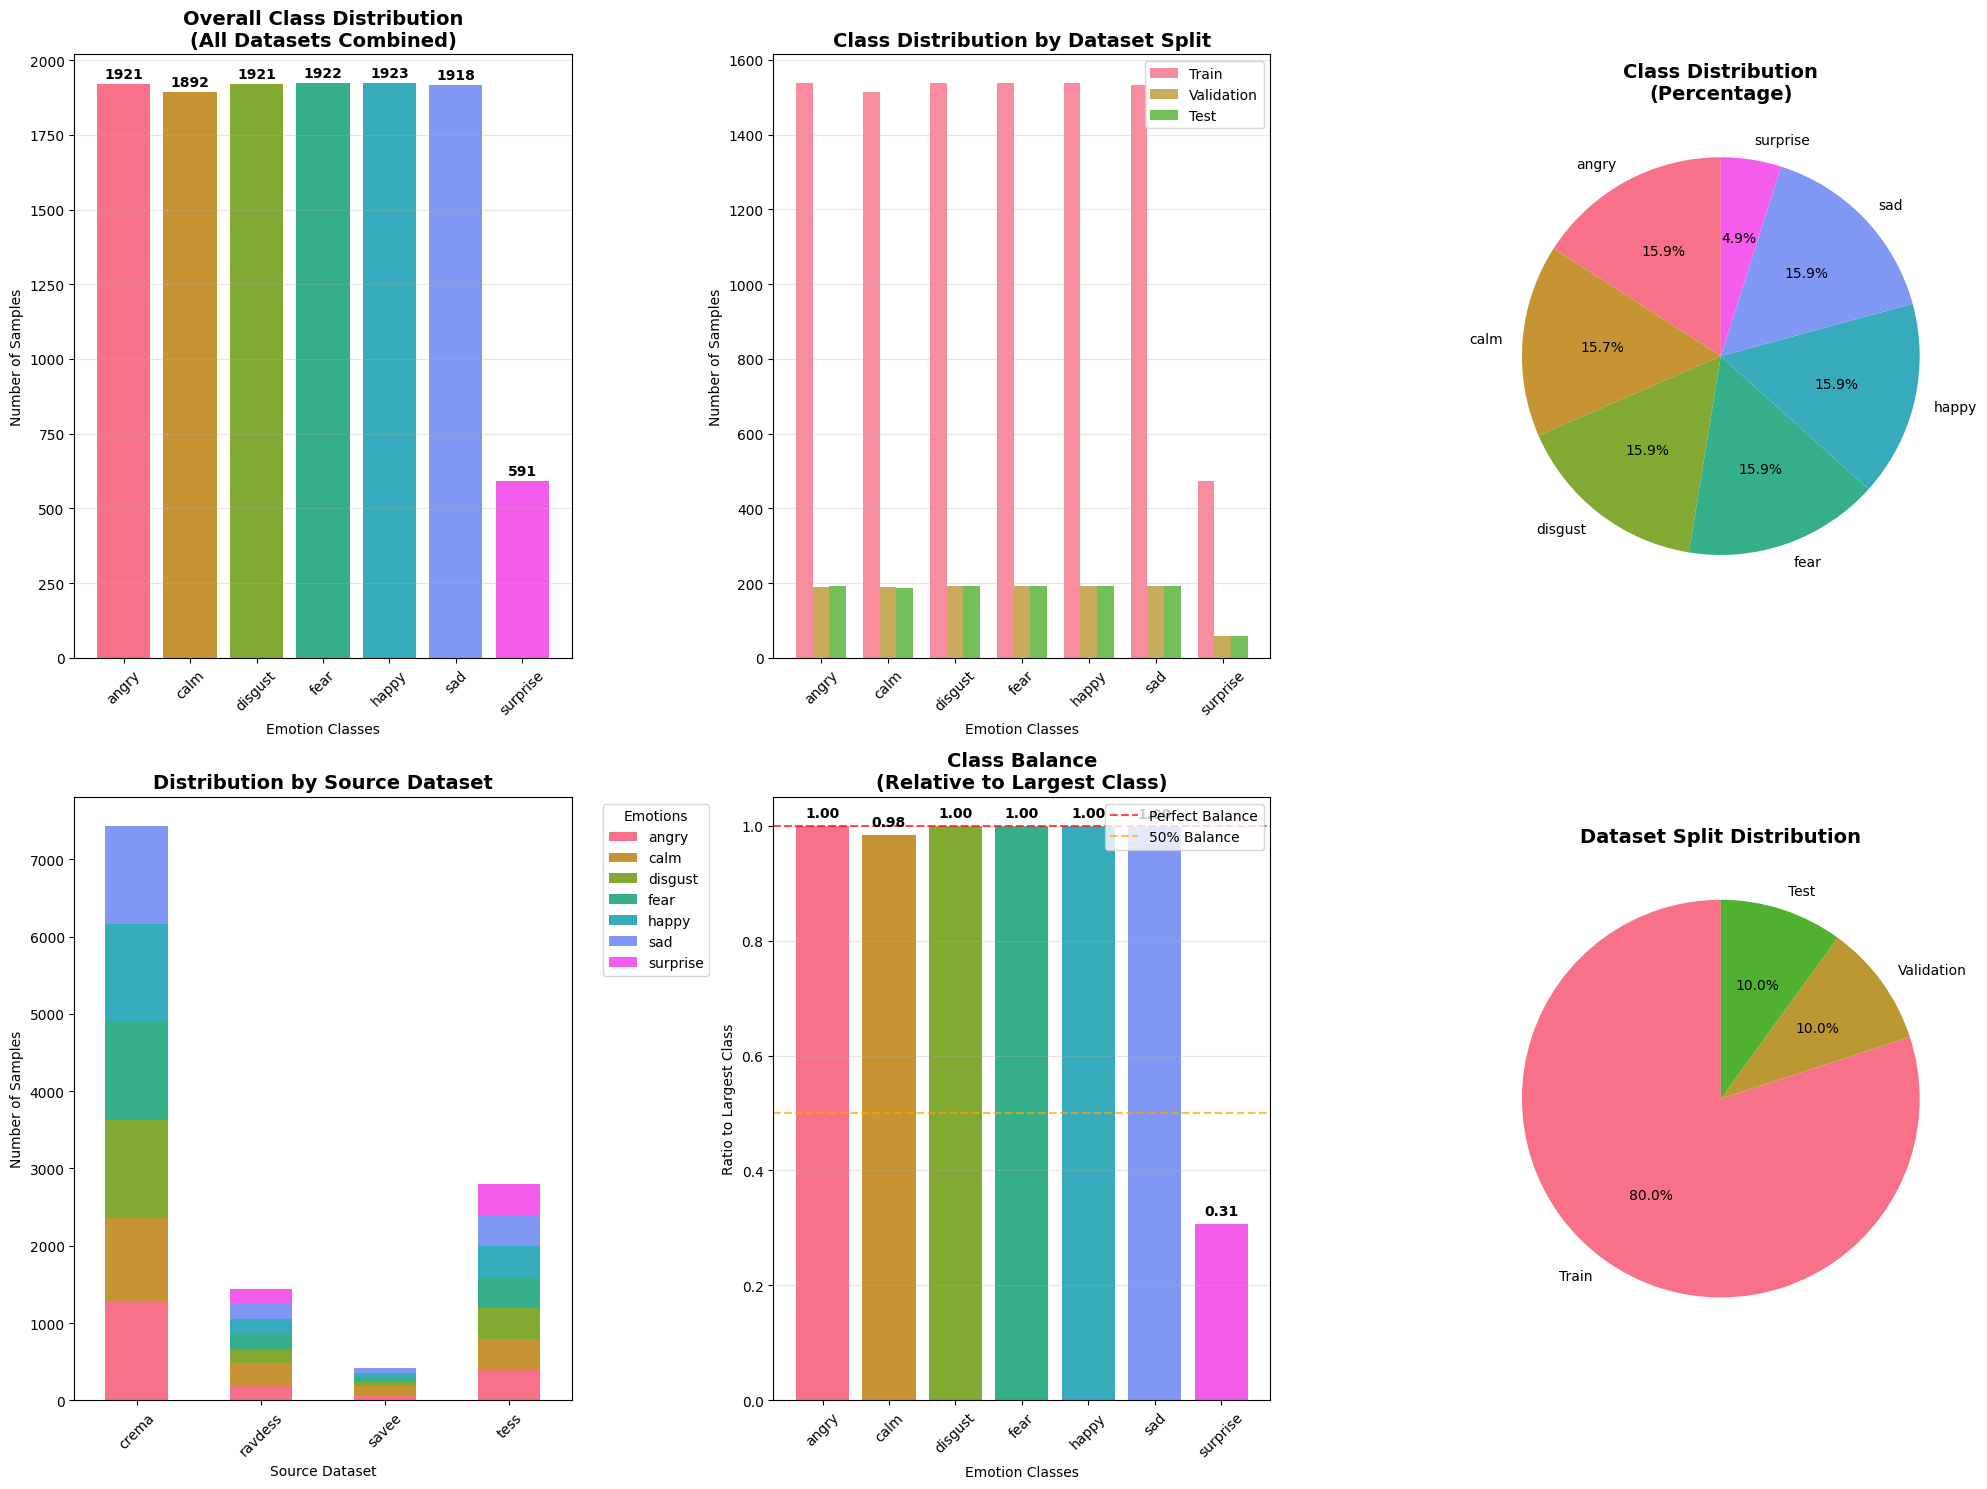

📊 Distribution plots saved to: /teamspace/studios/this_studio/speechSentimentAnalysis/processed_data/class_distribution_plots.png

💾 Distribution summary saved to: /teamspace/studios/this_studio/speechSentimentAnalysis/processed_data/class_distribution_summary.csv

🎉 Class distribution analysis complete!
📁 Results saved in: /teamspace/studios/this_studio/speechSentimentAnalysis/processed_data


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import json
from collections import Counter

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def load_processed_data():
    """Load the processed data and label mappings"""
    OUTPUT_DIR = Path("/teamspace/studios/this_studio/speechSentimentAnalysis/processed_data")
    
    # Load label mappings
    try:
        with open(OUTPUT_DIR / "label_mappings.json", "r") as f:
            mappings = json.load(f)
        label2id = mappings["label2id"]
        id2label = mappings["id2label"]
        print(f" Label mappings loaded: {label2id}")
    except Exception as e:
        print(f" Error loading label mappings: {e}")
        return None, None, None
    
    # Load processed datasets
    datasets = {}
    files_to_load = [
        ("train_processed.parquet", "Train"),
        ("valid_processed.parquet", "Validation"), 
        ("test_processed.parquet", "Test")
    ]
    
    for file_name, dataset_name in files_to_load:
        file_path = OUTPUT_DIR / file_name
        if file_path.exists():
            try:
                df = pd.read_parquet(file_path)
                datasets[dataset_name] = df
                print(f" Loaded {dataset_name}: {len(df)} samples")
            except Exception as e:
                print(f" Error loading {file_name}: {e}")
        else:
            print(f"File not found: {file_path}")
    
    return datasets, label2id, id2label

def plot_class_distributions(datasets, label2id, id2label):
    """Create comprehensive class distribution plots"""
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # Color palette
    colors = sns.color_palette("husl", len(label2id))
    emotion_colors = {emotion: colors[i] for i, emotion in enumerate(sorted(label2id.keys()))}
    
    # 1. Overall distribution across all datasets
    plt.subplot(2, 3, 1)
    all_labels = []
    for dataset_name, df in datasets.items():
        all_labels.extend(df['label'].tolist())
    
    label_counts = Counter(all_labels)
    emotions = sorted(label_counts.keys())
    counts = [label_counts[emotion] for emotion in emotions]
    
    bars = plt.bar(emotions, counts, color=[emotion_colors[emotion] for emotion in emotions])
    plt.title('Overall Class Distribution\n(All Datasets Combined)', fontsize=14, fontweight='bold')
    plt.xlabel('Emotion Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    
    # 2. Distribution by dataset (side by side)
    plt.subplot(2, 3, 2)
    dataset_names = list(datasets.keys())
    x = np.arange(len(emotions))
    width = 0.25
    
    for i, dataset_name in enumerate(dataset_names):
        df = datasets[dataset_name]
        dataset_counts = Counter(df['label'])
        dataset_values = [dataset_counts.get(emotion, 0) for emotion in emotions]
        
        plt.bar(x + i*width, dataset_values, width, 
               label=dataset_name, alpha=0.8)
    
    plt.title('Class Distribution by Dataset Split', fontsize=14, fontweight='bold')
    plt.xlabel('Emotion Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(x + width, emotions, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 3. Percentage distribution (pie chart)
    plt.subplot(2, 3, 3)
    plt.pie(counts, labels=emotions, autopct='%1.1f%%', startangle=90,
           colors=[emotion_colors[emotion] for emotion in emotions])
    plt.title('Class Distribution\n(Percentage)', fontsize=14, fontweight='bold')
    
    # 4. Distribution by source dataset
    plt.subplot(2, 3, 4)
    if 'dataset' in datasets['Train'].columns:
        all_source_data = []
        for dataset_name, df in datasets.items():
            temp_df = df[['label', 'dataset']].copy()
            temp_df['split'] = dataset_name
            all_source_data.append(temp_df)
        
        combined_df = pd.concat(all_source_data, ignore_index=True)
        
        # Create crosstab
        crosstab = pd.crosstab(combined_df['dataset'], combined_df['label'])
        
        # Plot stacked bar chart
        crosstab.plot(kind='bar', stacked=True, ax=plt.gca(), 
                     color=[emotion_colors[emotion] for emotion in crosstab.columns])
        plt.title('Distribution by Source Dataset', fontsize=14, fontweight='bold')
        plt.xlabel('Source Dataset')
        plt.ylabel('Number of Samples')
        plt.xticks(rotation=45)
        plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.text(0.5, 0.5, 'Source dataset information\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes,
                fontsize=12, style='italic')
        plt.title('Distribution by Source Dataset', fontsize=14, fontweight='bold')
    
    # 5. Class balance visualization
    plt.subplot(2, 3, 5)
    max_count = max(counts)
    balance_ratios = [count/max_count for count in counts]
    
    bars = plt.bar(emotions, balance_ratios, color=[emotion_colors[emotion] for emotion in emotions])
    plt.title('Class Balance\n(Relative to Largest Class)', fontsize=14, fontweight='bold')
    plt.xlabel('Emotion Classes')
    plt.ylabel('Ratio to Largest Class')
    plt.xticks(rotation=45)
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Balance')
    plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='50% Balance')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, ratio in zip(bars, balance_ratios):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{ratio:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Dataset split distribution
    plt.subplot(2, 3, 6)
    split_counts = [len(df) for df in datasets.values()]
    split_names = list(datasets.keys())
    
    plt.pie(split_counts, labels=split_names, autopct='%1.1f%%', startangle=90)
    plt.title('Dataset Split Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_detailed_statistics(datasets, label2id, id2label):
    """Print detailed statistics about the dataset"""
    print("\n" + "="*80)
    print("DETAILED CLASS DISTRIBUTION STATISTICS")
    print("="*80)
    
    # Overall statistics
    total_samples = sum(len(df) for df in datasets.values())
    print(f"\n OVERALL STATISTICS:")
    print(f"   Total samples: {total_samples:,}")
    print(f"   Number of emotion classes: {len(label2id)}")
    print(f"   Classes: {sorted(label2id.keys())}")
    
    # Class distribution across all datasets
    all_labels = []
    for dataset_name, df in datasets.items():
        all_labels.extend(df['label'].tolist())
    
    label_counts = Counter(all_labels)
    print(f"\n CLASS DISTRIBUTION (All datasets combined):")
    for emotion in sorted(label_counts.keys()):
        count = label_counts[emotion]
        percentage = (count / total_samples) * 100
        print(f"   {emotion:>10}: {count:>5,} samples ({percentage:>5.1f}%)")
    
    # Dataset split statistics
    print(f"\n DATASET SPLIT STATISTICS:")
    for dataset_name, df in datasets.items():
        print(f"   {dataset_name:>12}: {len(df):>5,} samples ({len(df)/total_samples*100:>5.1f}%)")
    
    # Class distribution by split
    print(f"\n CLASS DISTRIBUTION BY SPLIT:")
    for dataset_name, df in datasets.items():
        print(f"\n   {dataset_name.upper()} SET:")
        split_counts = Counter(df['label'])
        for emotion in sorted(split_counts.keys()):
            count = split_counts[emotion]
            percentage = (count / len(df)) * 100
            print(f"     {emotion:>10}: {count:>4} samples ({percentage:>5.1f}%)")
    
    # Class balance analysis
    print(f"\nCLASS BALANCE ANALYSIS:")
    max_count = max(label_counts.values())
    min_count = min(label_counts.values())
    balance_ratio = min_count / max_count
    
    print(f"   Most frequent class: {max_count:,} samples")
    print(f"   Least frequent class: {min_count:,} samples")
    print(f"   Balance ratio: {balance_ratio:.3f}")
    
    if balance_ratio > 0.8:
        print("Dataset is well-balanced")
    elif balance_ratio > 0.5:
        print("Dataset has moderate imbalance")
    else:
        print("Dataset has significant imbalance")
    
    # Source dataset distribution (if available)
    if 'dataset' in datasets['Train'].columns:
        print(f"\n📚 SOURCE DATASET DISTRIBUTION:")
        all_source_data = []
        for dataset_name, df in datasets.items():
            all_source_data.append(df[['label', 'dataset']])
        
        combined_df = pd.concat(all_source_data, ignore_index=True)
        source_counts = Counter(combined_df['dataset'])
        
        for source in sorted(source_counts.keys()):
            count = source_counts[source]
            percentage = (count / total_samples) * 100
            print(f"   {source.upper():>10}: {count:>5,} samples ({percentage:>5.1f}%)")

def save_distribution_summary(datasets, label2id, id2label):
    """Save distribution summary to CSV"""
    OUTPUT_DIR = Path("/teamspace/studios/this_studio/speechSentimentAnalysis/processed_data")
    
    # Create summary data
    summary_data = []
    
    # Overall distribution
    all_labels = []
    for dataset_name, df in datasets.items():
        all_labels.extend(df['label'].tolist())
    
    label_counts = Counter(all_labels)
    total_samples = len(all_labels)
    
    for emotion in sorted(label_counts.keys()):
        count = label_counts[emotion]
        percentage = (count / total_samples) * 100
        
        row = {
            'emotion': emotion,
            'total_samples': count,
            'percentage': percentage
        }
        
        # Add per-split counts
        for dataset_name, df in datasets.items():
            split_counts = Counter(df['label'])
            row[f'{dataset_name.lower()}_samples'] = split_counts.get(emotion, 0)
            row[f'{dataset_name.lower()}_percentage'] = (split_counts.get(emotion, 0) / len(df)) * 100
        
        summary_data.append(row)
    
    # Create DataFrame and save
    summary_df = pd.DataFrame(summary_data)
    summary_path = OUTPUT_DIR / "class_distribution_summary.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"\nDistribution summary saved to: {summary_path}")

def main():
    """Main function to run the class distribution analysis"""
    print("Starting Class Distribution Analysis")
    print("="*60)
    
    # Load the data
    datasets, label2id, id2label = load_processed_data()
    
    if not datasets:
        print("No datasets loaded. Make sure the processed files exist.")
        return
    
    # Print detailed statistics
    print_detailed_statistics(datasets, label2id, id2label)
    
    # Create visualizations
    print(f"\nCreating distribution plots...")
    fig = plot_class_distributions(datasets, label2id, id2label)
    
    # Save the plot
    OUTPUT_DIR = Path("/teamspace/studios/this_studio/speechSentimentAnalysis/processed_data")
    plot_path = OUTPUT_DIR / "class_distribution_plots.png"
    fig.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Distribution plots saved to: {plot_path}")
    
    # Save distribution summary
    save_distribution_summary(datasets, label2id, id2label)
    
    print(f"\n🎉 Class distribution analysis complete!")
    print(f"Results saved in: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()